# Case Study 1 - Evaluate impact from environmental events/pressures
## Description 
Aggregate observations of _Caladenia_ orchids in the ACT so I can analyse the relationship between records and the protection status and vegetation cover of the locations of each species.

This is an example of combining suites of spatial variables at different scales across multiple sites to analyse the factors correlated with a variable of interest. Comparable cases could include:
- Aggregate spatial data for frost and other extreme weather events associated with chickpeas and wheat yields to analyse the effects of such events on different varieties at different stages and advise growers on the best choices
- Aggregate pest data for the same pest across multiple sites and locations to analyse the relationship between population levels and environmental context at the time and over the previous month.

## Data sources
- **vegetation_cover_northern.tif** - GA Landsat Vegetation Cover GeoTIFF at 25m2 for the northern two thirds of the ACT and adjacent NSW in 2020: https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/67bb9d38-00c7-46ba-a5e9-b892d9f9ad42 (values defined here: https://knowledge.dea.ga.gov.au/data/product/dea-land-cover-landsat/?tab=details)
- **vegetation_cover_southern.tif** - GA Landsat Vegetation Cover GeoTIFF at 25m2 for the southern third of the ACT and adjacent NSW in 2020: https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/464fd7e2-0554-4095-80e1-42e00f087831
- **boundary_act.geojson** - 2023 boundary for the Australian Capital Territory from the ACT Government in GeoJSON format: https://actmapi-actgov.opendata.arcgis.com/datasets/ACTGOV::actgov-border/explore
- **capad_act.geojson** - Protected Area data for the Australian Capital Territory in 2022 from the CAPAD dataset in GeoJSON format: https://fed.dcceew.gov.au/datasets/ec356a872d8048459fe78fc80213dc70_0/explore?filters=eyJTVEFURSI6WyJBQ1QiXX0%3D&location=-35.437128%2C149.203518%2C11.00
- **caladenia_act.csv** - Distribution records for orchids in the genus _Caladenia_ between 1990 and present from the ALA in CSV format: https://doi.org/10.26197/ala.1e501311-7077-403b-a743-59e096068fa0

## Dependencies
- This notebook requires Python 3.10 or higher
- Install relevant Python libraries with: **pip install mccn-engine rocrate**
- Installing mccn-engine will install other dependencies

## Overview
1. Group orchid species records by species
2. Prepare STAC metadata records for each data source (separate records for the distribution data for each orchid species)
3. Load data cube
4. Mask orchid distribution records to boundaries of ACT
5. Calculate the proportion of distribution records for each species occurring inside and outside protected areas
6. Calculate the proportion of distribution records for each species occurring in areas with each class of vegetation cover
7. Report the apparent affinity between each species and protected areas and between each species and different classes of vegetation cover

## Notes
- No attempt is made here to compensate for underlying bias in the areas where observers have spent time recording orchids. The analysis should only be considered indicative of relative tendencies.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import pystac
import pystac_client
import subprocess
import json

from stac_generator.factory import StacGeneratorFactory
from stac_generator.core.base.generator import StacSerialiser
from stac_generator.core.base.schema import StacCollectionConfig, ColumnInfo
from stac_generator.core.raster.schema import RasterConfig, BandInfo
from stac_generator.core.vector.schema import VectorConfig
from stac_generator.core.point.schema import PointConfig

from mccn.client import MCCN

from rocrate.rocrate import ROCrate
from rocrate.model import ComputationalWorkflow, SoftwareApplication, File, Dataset, ContextEntity, Person

## Data Paths

In [2]:
# Paths to current folder, folder for STAC collection metadata and scratch folder for working files
current_folder = os.getcwd()
source_folder = os.path.join(current_folder, "source_data")
stac_folder = os.path.join(current_folder, "stac")
scratch_folder = os.path.join(current_folder, "scratch")
results_folder = os.path.join(current_folder, "results")

# Create clean folders for outputs
for f in [stac_folder, scratch_folder, results_folder]:
    if os.path.exists(f):
        shutil.rmtree(f)
    os.makedirs(f)

# Path to this notebook
notebook = "MCCN-CASE 1.ipynb"

# Paths to source files
cover_n_source = os.path.join(source_folder, "vegetation_cover_northern.tif")
cover_s_source = os.path.join(source_folder, "vegetation_cover_southern.tif")
caladenia_source = os.path.join(source_folder, "caladenia_act.csv")
boundary_source = os.path.join(source_folder, "boundary_act.geojson")
capad_source = os.path.join(source_folder, "capad_act.geojson")

# Paths to results files
datacube_initial = os.path.join(results_folder, "Caladenia_study_initial.dc")
datacube_final = os.path.join(results_folder, "Caladenia_study_final.dc")
protection_affinity_result = os.path.join(results_folder, "Caladenia_protection_status_affinities.csv")
vegetation_affinity_result = os.path.join(results_folder, "Caladenia_vegetation_affinities.csv")

# Path to generated RO-Crate results package
ro_crate = "MCCN-CASE 1.RO-Crate.zip"
if os.path.exists(ro_crate):
    os.remove(ro_crate)

## Prepare orchid datasets

All orchid species are included in a single file with many columns. Only the scientific name and coordinates are relevant for this case study. Different species may have occurred at the same coordinates. Importing the complete file as a single xarray DataArray would leave only one scientific name for each point. So we split the file into one for each species with 10 or more records.

Records with incomplete coordinates or uncertainty greater than 1000 m are excluded. For a real analysis, greater precision would be required.

In [3]:
# Read caladenia_source, discard all columns but the scientific name and coordinates, and drop all records without complete coordinates or low precision.
caladenia = pd.read_csv(caladenia_source, encoding="UTF8")[["scientificName", "decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"]]
caladenia = caladenia[~((caladenia["decimalLatitude"].isna()) | (caladenia["decimalLatitude"].isna()) | (caladenia["coordinateUncertaintyInMeters"] > 1000))]

# Generate separate CSV files for each species with 10 or more observations (filenames held in species_files)
species = caladenia.rename(columns= {'decimalLatitude':'count'}).groupby("scientificName")["count"].count().reset_index()
species = species[species["count"] >= 10]["scientificName"].tolist()

# Generate blank-free keys for each species and save data for each species to a corresponding filename.
species_keys = [s.replace(' ', '_') for s in species]
species_files = {s: os.path.join(scratch_folder, f"{s}.csv") for s in species_keys}

for s, sk in zip(species, species_keys):
    sf = species_files[sk]
    caladenia_subset = caladenia.loc[caladenia["scientificName"] == s].copy()
    caladenia_subset[sk] = 1.0
    caladenia_subset.to_csv(sf, encoding="utf8")

## Generate configuration files for STAC collection

Create STAC configuration settings in memory for each data source and use these to generate STAC metadata to describe each object. Metadata is serialised into the stac folder. On completion, this folder contains collection.json at the root and subfolders with JSON STAC metadaat for each data layer to be imported.

In [4]:
# Configuration for collection as a whole.
collection_config = StacCollectionConfig(
    id="CaladeniaStudy",
    title="Datasets for Caladenia case study",
    description="STAC records for accessing datasets to explore as part of the MCCN case study 1 relating to distribution of orchids in the genus Caladenia in the northern ACT",
    license="CC-BY-4.0",
)

# List of configurations for individual data layers.
configurations = [
    
    VectorConfig(
        id="ACT_Boundary",
        location=os.path.join(current_folder, boundary_source),
        collection_date="2024-12-31",
        collection_time="00:00:00"
    ),

    VectorConfig(
        id="ACT_CAPAD",
        location=os.path.join(current_folder, capad_source),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        column_info=[
            ColumnInfo(name="PA_ID"),
        ]
    ),

    RasterConfig(
        id="Vegetation_Cover_Northern",
        location=os.path.join(current_folder, cover_n_source),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        band_info=[
            BandInfo(name="vegetation_north", description="Vegetation cover level")
        ]
    ),

    RasterConfig(
        id="Vegetation_Cover_Southern",
        location=os.path.join(current_folder, cover_s_source),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        band_info=[
            BandInfo(name="vegetation_south", description="Vegetation cover level")
        ]
    ),
] + [
    PointConfig(
        id=sk,
        location=os.path.join(current_folder, species_files[sk]),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        X="decimalLongitude",
        Y="decimalLatitude",
        column_info=[
            ColumnInfo(name=sk, description=f"{s} reported as present"),
        ]
    ) for sk in species_keys
]

# Build the generator using the configurations.
generator = StacGeneratorFactory.get_collection_generator(
    source_configs=configurations,
    collection_config=collection_config
)

# Serialise the STAC collection. This will generate the collection JSON file and item JSON files for each layer.
serialiser = StacSerialiser(generator, stac_folder)
serialiser()

2025-05-28T14:41:52-stac_generator.core.vector.generator - INFO - Reading vector asset: ACT_Boundary
2025-05-28T14:41:52-stac_generator.core.vector.generator - INFO - Reading vector asset: ACT_CAPAD
2025-05-28T14:41:52-stac_generator.core.raster.generator - INFO - Reading raster asset: Vegetation_Cover_Northern
2025-05-28T14:41:52-stac_generator.core.raster.generator - INFO - Reading raster asset: Vegetation_Cover_Southern
2025-05-28T14:41:52-stac_generator.core.point.generator - INFO - Reading point asset: Caladenia_alpina
2025-05-28T14:41:52-stac_generator.core.point.generator - INFO - Reading point asset: Caladenia_atrovespa
2025-05-28T14:41:52-stac_generator.core.point.generator - INFO - Reading point asset: Caladenia_carnea
2025-05-28T14:41:52-stac_generator.core.point.generator - INFO - Reading point asset: Caladenia_catenata
2025-05-28T14:41:52-stac_generator.core.point.generator - INFO - Reading point asset: Caladenia_congesta
2025-05-28T14:41:52-stac_generator.core.point.gener

## DataCube Load
Load data for all STAC items for the vegetation cover, ACT boundary, CAPAD shapes and orchid species records into a new data cube, using the boundary, CRS and shape from the vegetation cover layer. Use a 400 * 400 canvas and fill areas without values with 0.

In [5]:
# Using the locally generated collection
endpoint = os.path.join(stac_folder, "collection.json")
client = MCCN(endpoint, shape=400, nodata=0)
ds = client.load()

MCCN.to_netcdf(ds, datacube_initial)

# The xarray includes a time dimension with a single position. Removing this dimension simplifies the indexing in all later steps.
ds = ds.isel(time=0)

# Variable containing all ones for simplified masking
ds["all_ones"] = 1

# Display DataSet.
ds

<xarray.Dataset> Size: 22MB
Dimensions:                (y: 400, x: 400)
Coordinates:
  * y                      (y) float64 3kB -34.71 -34.71 -34.72 ... -36.6 -36.61
  * x                      (x) float64 3kB 148.5 148.5 148.5 ... 150.8 150.8
    spatial_ref            int32 4B 4326
    time                   datetime64[ns] 8B 2024-12-30T13:00:00
Data variables: (12/21)
    vegetation_north       (y, x) float64 1MB 255.0 255.0 255.0 ... 255.0 255.0
    vegetation_south       (y, x) float64 1MB 255.0 255.0 255.0 ... 255.0 255.0
    ACT_Boundary           (y, x) int8 160kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    PA_ID                  (y, x) int8 160kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ACT_CAPAD              (y, x) int8 160kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Caladenia_alpina       (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                     ...
    Caladenia_moschata     (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_phaeoclavia  (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_picta        (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_praecox      (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_ustulata     (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    all_ones               int64 8B 1
Attributes:
    ACT_Boundary:  {"0": "nodata", "1": "ACT_Boundary"}
    PA_ID:         {"0": "nodata", "1": "ACT_34", "2": "ACT_01", "3": "ACT_03...
    ACT_CAPAD:     {"0": "nodata", "1": "ACT_CAPAD"}

## Organise Vegetation Cover
The two tiles for vegetation cover together completely overlay the ACT (excluding Jervis Bay). The tiles use the following pixel values:

- 0: Not applicable (such as in bare areas)
- 10: Closed (>65%)
- 12: Open (40 to 65%)
- 13: Open (15 to 40%)
- 15: Sparse (4 to 15%)
- 16: Scattered (1 to 4%)

Since 0 is a meaningful value in these data, the tiles specify use of 255 as the fill value where there is no data. To merge these tiles into a single variable, we will first replace these 255 pixels with 0. This will not impact subsequent analysis (since usage will be restricted to the ACT area and all 0 values in that area are significant), but it simplifies the combining of the two tiles.

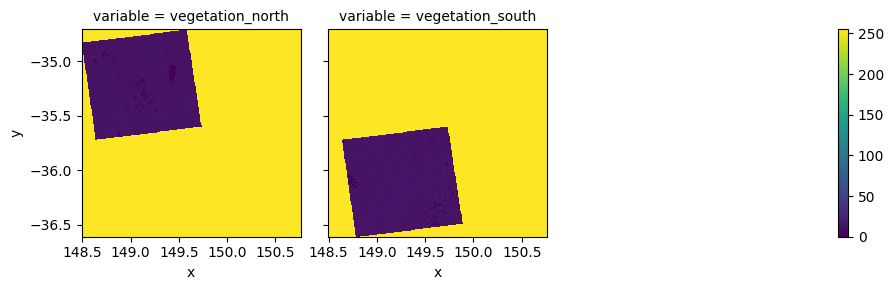

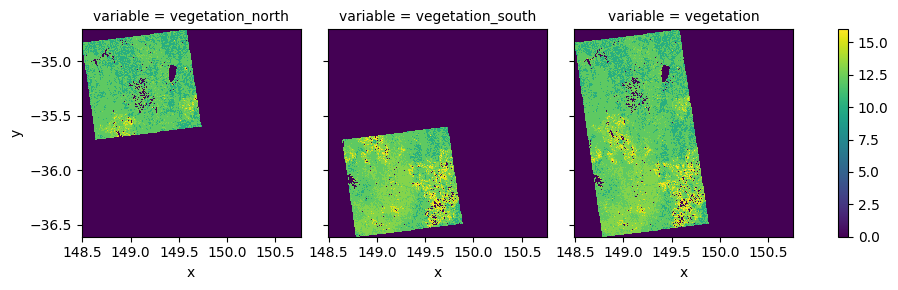

In [6]:
# Display imported form of vegetation tiles.
ds[["vegetation_north", "vegetation_south"]].to_array().plot(x="x", col="variable", col_wrap=3)

# Clean and merge tiles.
ds["vegetation_north"] = ds.vegetation_north.where(ds.vegetation_north < 255, 0)
ds["vegetation_south"] = ds.vegetation_south.where(ds.vegetation_south < 255, 0)
ds["vegetation"] = ds.vegetation_north.where(ds.vegetation_north > 0, ds.vegetation_south)

# Display clean and merged layers.
ds[["vegetation_north", "vegetation_south", "vegetation"]].to_array().plot(x="x", col="variable", col_wrap=3)

## Organise Protected Areas
The source data includes separate shapes for each ACT protected area.

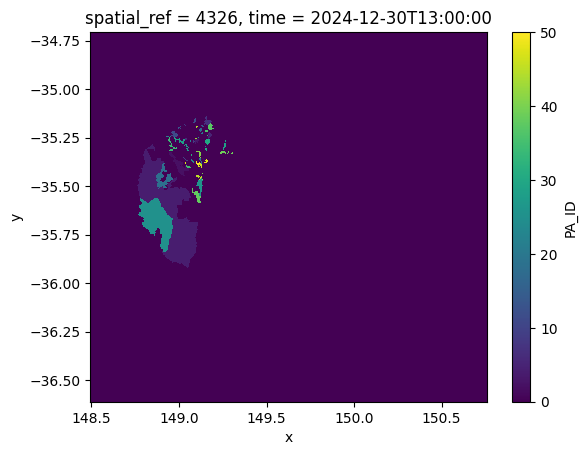

In [7]:
# Display original variable
ds.PA_ID.plot(x="x")

Merge all protected area shapes into a single mask with 1 for protected area pixels and 0 otherwise.

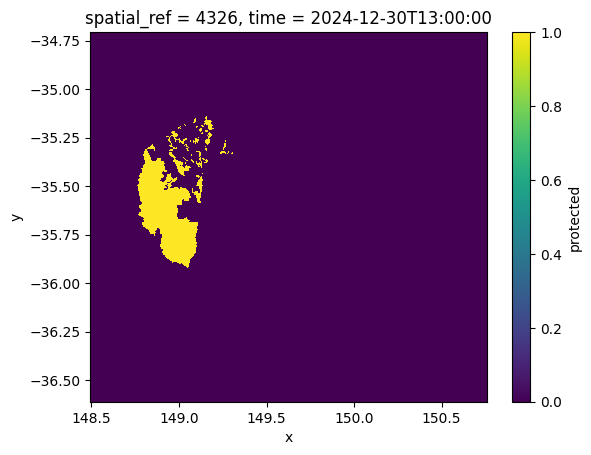

In [8]:
# Unify protected areas into a single mask
ds["protected"] = ds.PA_ID.where(ds.PA_ID == 0, 1)
ds.protected.plot(x="x")

## Organise Species data
Get counts of remaining pixels for each species and drop layers with fewer than 10 records.

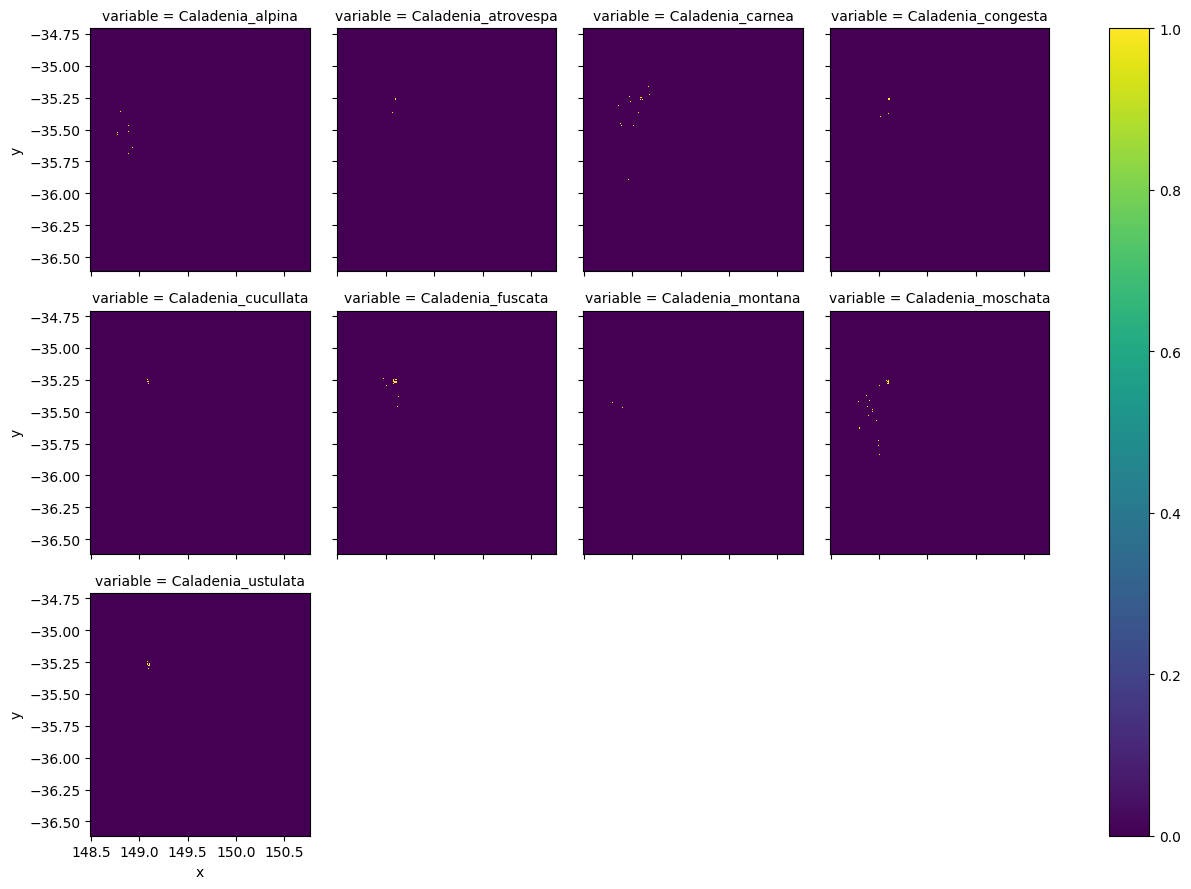

In [9]:
# Collect counts of pixels per species for later use
species_pixels = {}
common_species_keys = []
for s in species_keys:
    species_pixels[s] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds[s] == 1, 0)).sum().item()

    # Drop species with fewer than 10 records
    if species_pixels[s] < 10:
        ds = ds.drop_vars(s)
    else:
        common_species_keys.append(s)

species_keys = common_species_keys

# Display grid of point distributions for remaining species
ds[species_keys] = ds[species_keys].where(ds.ACT_Boundary > 0, 0).astype(int)
ds[species_keys].to_array().plot(x="x", col="variable", col_wrap=4)

Display number of species recorded from each pixel.

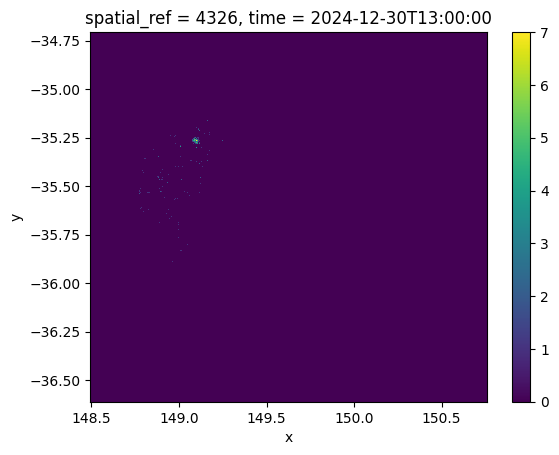

In [10]:
# Show species density per pixel
ds[species_keys].to_array().sum("variable").plot(x="x")

## Calculate Affinities
Given the number of pixels in which each species has been recorded in the ACT and the number of pixels that are protected and not protected and the number of pixels with each specified class of vegetation cover, calculate whether each species shows any apparent affinity for protected areas over unprotected areas (or vice versa) or for any vegetation cover classes.

In [11]:
# Dictionary of vegetation cover levels - organise keys in a sensible order.
levels = {
    0: "Not applicable (such as in bare areas)",
    10: "Closed (>65 %)",
    12: "Open (40 to 65 %)",
    13: "Open (15 to 40 %)",
    15: "Sparse (4 to 15 %)",
    16: "Scattered (1 to 4 %)",
}

level_keys = sorted(levels.keys())
level_keys[-1] = level_keys.pop(0)

# Dictionary of protected area statuses.
protection = {
    0: "unprotected",
    1: "protected",
}

protection_keys = sorted(protection.keys())

# Pandas dataframes to contain results. 
# The "Total pixels" row and column are to store the number of pixels associated with each row or column. 
# Other cells will contain measures of affinity between a species and a class of pixels (vegetation cover level or protected area status).
vegetation_affinity = pd.DataFrame(index=(["Total pixels"] + species_keys), columns=(["Total pixels"] + [levels[l] for l in level_keys]))
protection_affinity = pd.DataFrame(index=(["Total pixels"] + species_keys), columns=(["Total pixels"] + [protection[p] for p in protection_keys]))

# Count of total number of pixels in study area (i.e. ACT).
study_pixels = ds.ACT_Boundary.sum().item()
vegetation_affinity.loc["Total pixels", ["Total pixels"]] = study_pixels
protection_affinity.loc["Total pixels", ["Total pixels"]] = study_pixels

# Counts of number of pixels associated with each vegetation cover level.
level_pixels = {}
for l in level_keys:
    level_pixels[l] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds.vegetation == l, 0)).sum().item()
    vegetation_affinity.loc["Total pixels", [levels[l]]] = level_pixels[l]

# Counts of number of pixels associated with each protected area status.
protection_pixels = {}
for p in protection_keys:
    protection_pixels[p] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds.protected == p, 0)).sum().item()
    protection_affinity.loc["Total pixels", [protection[p]]] = protection_pixels[p]

# Counts of number of pixels in which each species has been recorded
species_pixels = {}
for s in species_keys:
    species_pixels[s] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds[s] == 1, 0)).sum().item()
    vegetation_affinity.loc[s, ["Total pixels"]] = species_pixels[s]
    protection_affinity.loc[s, ["Total pixels"]] = species_pixels[s]

    # Counts of number of pixels in each vegetation cover level which each species has been recorded and number expected if distribution is random. Affinity is defined as the ratio of these numbers.
    for l in level_keys:
        observed = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds[s].where(ds[s] == 0, ds.all_ones.where(ds.vegetation == l, 0))).sum().item()
        expected = (species_pixels[s] * level_pixels[l]) / study_pixels
        vegetation_affinity.loc[s, [levels[l]]] = observed / expected

    # Counts of number of pixels in each protected area status which each species has been recorded and number expected if distribution is random. Affinity is defined as the ratio of these numbers.
    for p in protection_keys:
        observed = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds[s].where(ds[s] == 0, ds.all_ones.where(ds.protected == p, 0))).sum().item()
        expected = (species_pixels[s] * protection_pixels[p]) / study_pixels
        protection_affinity.loc[s, [protection[p]]] = observed / expected

## Results For Affinity Between Species And Vegetation Cover
Based on the ALA data, most species prefer moderately open (40-65%) cover, but _Caladenia alpina_ and _Caladenia montana_ have most often been recorded in more open locations.

In [12]:

# Display vegetation affinity results
vegetation_affinity

,Total pixels,Closed (>65 %),Open (40 to 65 %),Open (15 to 40 %),Sparse (4 to 15 %),Not applicable (such as in bare areas)
Total pixels,8678,709,4559,2173,542,621
Caladenia_alpina,13,0.0,1.171377,1.228787,0.0,1.074941
Caladenia_atrovespa,15,0.815985,1.52279,0.532474,0.0,0.0
Caladenia_carnea,39,0.941521,1.513029,0.307197,0.0,0.716627
Caladenia_congesta,14,0.87427,1.359634,0.855762,0.0,0.0
Caladenia_cucullata,10,0.0,1.52279,0.399356,0.0,1.397424
Caladenia_fuscata,48,0.764986,1.506928,0.249597,0.0,1.16452
Caladenia_montana,12,0.0,0.634496,1.331186,4.002768,0.0
Caladenia_moschata,50,0.244795,1.256302,0.798711,0.640443,0.558969
Caladenia_ustulata,23,0.0,1.655207,0.347266,0.0,0.607575


## Results For Affinity Between Species And Protection Status
Based on the ALA data, several species show a clear affinity with protected areas (particularly the montane species which do not occur closer to the city).

However, some species have been recorded more prominently in unprotected areas. This should not be treated as a significant result. It most likely reflects the activities of citizen scientists.

In [13]:

# Display protection affinity results
protection_affinity

,Total pixels,unprotected,protected
Total pixels,8678,3818,4860
Caladenia_alpina,13,0.0,1.785597
Caladenia_atrovespa,15,1.212223,0.833278
Caladenia_carnea,39,0.757639,1.190398
Caladenia_congesta,14,0.811756,1.147884
Caladenia_cucullata,10,0.909167,1.071358
Caladenia_fuscata,48,1.136459,0.892798
Caladenia_montana,12,0.18941,1.636797
Caladenia_moschata,50,0.772792,1.178494
Caladenia_ustulata,23,1.087048,0.931616


## Finalise
Clean up temporary files. Write Xarray and Pandas outputs to the results folder. Package everything as an RO-Crate.

In [ ]:
# Clean up scratch folder
if os.path.exists(scratch_folder):
    shutil.rmtree(scratch_folder)

# Save output datasets
MCCN.to_netcdf(ds, datacube_final)
vegetation_affinity.to_csv(vegetation_affinity_result)
protection_affinity.to_csv(protection_affinity_result)

# Package notebook, source data and outputs as an RO-Crate
crate = ROCrate()
ardc = crate.add(ContextEntity(crate, "https://ror.org/038sjwq14", properties={
    "@type": "Organisation",
    "name": "Australian Research Data Commons"
}))
appn = crate.add(ContextEntity(crate, "https://ror.org/02zj7b759", properties={
    "@type": "Organisation",
    "name": "Australian Plant Phenomics Network"
}))
dgh = crate.add(Person(crate, "https://orcid.org/0000-0001-6492-4016", properties={
    "name": "Donald Hobern",
    "email": "donald.hobern@adelaide.edu.au",
    "affiliation": {"@id": appn.id},
    "jobTitle": "APPN Data Management Director",
}))
food_security = crate.add(ContextEntity(crate, "https://doi.org/10.47486/DC105", properties={
    "@type": "Grant",
    "name": "ARDC Project Code DC105: Multi-Scalar Crop Characterisation Network (MCCN)",
    "funder": {"@id": ardc.id}
}))
mccn = crate.add(ContextEntity(crate, "https://doi.org/10.26292/8679d473", properties={
    "@type": "ResearchActivity",
    "name": "Multi-Scalar Crop Characterisation Network (MCCN)",
    "funding": {"@id": food_security.id},
    "contactPoint": {"@id": dgh.id},
}))
cc_by = crate.add(ContextEntity(crate, "https://creativecommons.org/licenses/by/4.0/", properties={
    "@type": "License",
    "name": "Creative Commons Attribution 4.0 International (CC BY 4.0)",
}))
crate_properties = crate.default_entities[0].properties()
crate_properties |= {
    "name": "MCCN Case Study 1 - source data, notebook and results",
    "description": "This RO-Crate is a packaged version of the Jupyter notebook for Case Study 1 of the Multiscalar Crop Characterisation Network (MCCN) project. It demonstrates the functionality of the Python packages pystac-generator and mccn-engine developed as part of this project.",
    "license": {"@id": cc_by.id},
    "maintainer": {"@id": mccn.id},
}
crate.add(File(crate, source=(cover_n_source := os.path.relpath(cover_n_source, current_folder)), dest_path=cover_n_source, properties={
    "name": "GA Landsat Vegetation Cover GeoTIFF at 25m2 for the northern two thirds of the ACT and adjacent NSW in 2020",
    "encodingFormat": "image/tiff",
    "identifier": "67bb9d38-00c7-46ba-a5e9-b892d9f9ad42",
    "keywords": "ga_ls_landcover_class_cyear_2_1-0-0_au_2020-01-01",
    "producer": "ga.gov.au",
    "citation": "Geoscience Australia Landsat Land Cover Calendar Year Collection 2.0",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/67bb9d38-00c7-46ba-a5e9-b892d9f9ad42"}
}))
crate.add(File(crate, source=(cover_s_source := os.path.relpath(cover_s_source, current_folder)), dest_path=cover_s_source, properties={
    "name": "GA Landsat Vegetation Cover GeoTIFF at 25m2 for the southern third of the ACT and adjacent NSW in 2020",
    "encodingFormat": "image/tiff",
    "identifier": "464fd7e2-0554-4095-80e1-42e00f087831",
    "keywords": "ga_ls_landcover_class_cyear_2_1-0-0_au_2020-01-01",
    "producer": "ga.gov.au",
    "citation": "Geoscience Australia Landsat Land Cover Calendar Year Collection 2.0",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/464fd7e2-0554-4095-80e1-42e00f087831"}
}))
crate.add(File(crate, source=(boundary_source := os.path.relpath(boundary_source, current_folder)), dest_path=boundary_source, properties={
    "name": "2023 boundary for the Australian Capital Territory from the ACT Government in GeoJSON format",
    "encodingFormat": "application/geo+json",
    "producer": "act.gov.au",
    "citation": "ACTGOV BORDER, Australian Capital Territory Government",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://actmapi-actgov.opendata.arcgis.com/datasets/ACTGOV::actgov-border/explore"}
}))
crate.add(File(crate, source=(capad_source := os.path.relpath(capad_source, current_folder)), dest_path=capad_source, properties={
    "name": "Protected Area data for the Australian Capital Territory in 2022 from the CAPAD dataset in GeoJSON format",
    "encodingFormat": "application/geo+json",
    "producer": "environment.gov.au",
    "license": {"@id": cc_by.id},
    "citation": "Collaborative Australian Protected Areas Database (CAPAD) 2024, Commonwealth of Australia 2025",
    "url": {"@id": "https://fed.dcceew.gov.au/datasets/ec356a872d8048459fe78fc80213dc70_0/explore?filters=eyJTVEFURSI6WyJBQ1QiXX0%3D&location=-35.437128%2C149.203518%2C11.00"}
}))
crate.add(File(crate, source=(caladenia_source := os.path.relpath(caladenia_source, current_folder)), dest_path=caladenia_source, properties={
    "name": "Atlas of Living Australia Occurrence records download on 2024-11-19 for Caladenia species in Australian Capital Territory",
    "license": {"@id": "https://doi.ala.org.au/doi/1e501311-7077-403b-a743-59e096068fa0", "description": "Mix of CC0, CC-BY-NC-SA 4.0 (Int), CC-BY-SA 4.0 (Int), Creative Commons - license at record level, CC-BY-NC 4.0 (Int), CC-BY 4.0 (Int), CC-BY, CC-BY-NC, CC-BY-NC 3.0 (Au)"},
    "encodingFormat": "application/zip",
    "producer": "environment.gov.au",
    "citation": "Atlas of Living Australia occurrence download at https://biocache.ala.org.au/occurrences/search?&q=lsid%3Ahttps%3A%2F%2Fid.biodiversity.org.au%2Ftaxon%2Fapni%2F51458817&fq=state%3A%22Australian+Capital+Territory%22&fq=%28occurrence_decade_i%3A%221990%22+OR+occurrence_decade_i%3A%222000%22+OR+occurrence_decade_i%3A%222010%22+OR+occurrence_decade_i%3A%222020%22%29&disableAllQualityFilters=true&fq=-basisOfRecord%3A%22FOSSIL_SPECIMEN%22+AND+-%28basisOfRecord%3A%22MATERIAL_SAMPLE%22+AND+contentTypes%3A%22Environmental+DNA%22%29&fq=-%28duplicate_status%3A%22ASSOCIATED%22+AND+duplicateType%3A%22DIFFERENT_DATASET%22%29&fq=-assertions%3ATAXON_MATCH_NONE+AND+-assertions%3AINVALID_SCIENTIFIC_NAME+AND+-assertions%3ATAXON_HOMONYM+AND+-assertions%3AUNKNOWN_KINGDOM+AND+-assertions%3ATAXON_SCOPE_MISMATCH&fq=-occurrenceStatus%3AABSENT&fq=-identificationVerificationStatus%3A%22needs_id%22&fq=-userAssertions%3A50001+AND+-userAssertions%3A50005&fq=-year%3A%5B*+TO+1700%5D&fq=-establishmentMeans%3A%22MANAGED%22+AND+-decimalLatitude%3A0+AND+-decimalLongitude%3A0+AND+-assertions%3A%22PRESUMED_SWAPPED_COORDINATE%22+AND+-assertions%3A%22COORDINATES_CENTRE_OF_STATEPROVINCE%22+AND+-assertions%3A%22COORDINATES_CENTRE_OF_COUNTRY%22+AND+-assertions%3A%22PRESUMED_NEGATED_LATITUDE%22+AND+-assertions%3A%22PRESUMED_NEGATED_LONGITUDE%22&fq=-outlierLayerCount%3A%5B3+TO+*%5D&fq=-spatiallyValid%3A%22false%22&fq=-coordinateUncertaintyInMeters%3A%5B10001+TO+*%5D&qc=-_nest_parent_%3A* accessed on 19 November 2024.",
    "url": {"@id": "https://doi.org/10.26197/ala.1e501311-7077-403b-a743-59e096068fa0"}
}))
crate.add(File(crate, source=(datacube_initial := os.path.relpath(datacube_initial, current_folder)), dest_path=datacube_initial, properties={
    "name": "Xarray datacube as loaded from source data files by MCCN Case Study 1",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(datacube_final := os.path.relpath(datacube_final, current_folder)), dest_path=datacube_final, properties={
    "name": "Xarray datacube following processing by MCCN Case Study 1",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(protection_affinity_result := os.path.relpath(protection_affinity_result, current_folder)), dest_path=protection_affinity_result, properties={
    "name": "CSV table of relative prominence of protected and unprotected areas in distributions of ACT Caladenia species",
    "license": {"@id": cc_by.id},
    "encodingFormat": "text/csv",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(vegetation_affinity_result := os.path.relpath(vegetation_affinity_result, current_folder)), dest_path=vegetation_affinity_result, properties={
    "name": "CSV table of relative prominence of areas with different classes of vegetation cover in distributions of ACT Caladenia species",
    "license": {"@id": cc_by.id},
    "encodingFormat": "text/csv",
    "producer": {"@id": appn.id},
}))
mccn_engine = crate.add(SoftwareApplication(crate, "https://github.com/aus-plant-phenomics-network/mccn-engine", properties={
    "name": "MCCN-Engine",
    "description": "Python library for loading and combining STAC-described assets, into an xarray datacube",
    "maintainer": {"@id": mccn.id},
}))
stac_generator = crate.add(SoftwareApplication(crate, "https://github.com/aus-plant-phenomics-network/stac-generator", properties={
    "name": "STAC Generator",
    "description": "Python library that combines automatically extracted geospatial information from raw assets and other user-provided metadata to build a STAC-compliant metadata record for further use",
    "maintainer": {"@id": mccn.id},
}))
crate.add(ComputationalWorkflow(crate, source=notebook, dest_path=notebook, properties={
    "name": "MCCN Case Study 1 Notebook: Evaluate impact from environmental events/pressures",
    "encodingFormat": "application/x-ipynb+json",
    "creator": {"@id": dgh.id},
    "maintainer": {"@id": mccn.id},
    "license": {"@id": cc_by.id},
    "softwareRequirements": [
        {"@id": mccn_engine.id},
        {"@id": stac_generator.id},
    ],
    "input": [
        { "@id": cover_n_source},
        { "@id": cover_s_source},
        { "@id": boundary_source},
        { "@id": capad_source},
        { "@id": caladenia_source},
    ],
    "output": [
        { "@id": datacube_initial},
        { "@id": datacube_final},
        { "@id": protection_affinity_result},
        { "@id": vegetation_affinity_result},
    ],
}))
crate.write_zip(ro_crate)

'/home/dhobern/projects/mccn-case-studies/Case 1/MCCN-CASE 1.RO-Crate.zip'